* Autoencoders are pretty neat, but can we improve our models ability to understand the multi-dimensional space of our data?
    + In this notebook we'll play with `variational autoencoders` to get a better feel for how they work and understand how they improve upon our vanilla autoencoder

In [ ]:
#| echo: false
from data import *
from utils import *
from model import *

In [ ]:
#| echo: false
plt.style.use('dark_background')

In [ ]:
#| echo: false
#| output: false
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dls, train_df, valid_df = get_data()

## Dataset

* Our dataset is MNIST
    + A selection of ~70,000 handwritten digits -- a few sampels can be seen below:

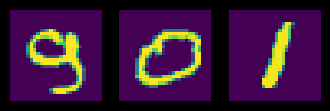

In [ ]:
#| echo: true
plot_dataset(train_df, num_samples=3)

In [ ]:
mean=0.0 
std=0.05
torch.normal(mean=torch.tensor(mean), std=torch.tensor(std),
            size=(2,2))

tensor([[ 0.0120,  0.0284],
        [ 0.0093, -0.0799]])

In [ ]:
batch = next(iter(dls.train))
batch[0].to('cpu'); 
batch[1].to('cpu');
batch[0].shape

torch.Size([64, 1, 28, 28])

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, conv_channels=[28,64,128]):
        super(Encoder, self).__init__()
        self.int_conv_layers = conv_channels
        self.conv_body = self.get_conv_layers()
        
    def get_conv_layers(self, flatten=True):
        conv_layers = torch.nn.ModuleList()
        for x in range(len(self.int_conv_layers)):
            if x==0: in_ch=1
            else: in_ch = self.int_conv_layers[x-1]
            out_ch = self.int_conv_layers[x]
            conv_layers.append(self.get_conv(in_ch, out_ch))
        if flatten: conv_layers.append(torch.nn.Flatten())
        return torch.nn.Sequential(*conv_layers)
                                                    
    
    def get_conv(self, in_ch, out_ch, activation=True, 
                 batch_norm=True):
        conv_layer = torch.nn.ModuleList([torch.nn.Conv2d(in_ch, out_ch, 
                                                          kernel_size=3, 
                                                          stride=2, 
                                                          padding=1),])
        if activation: conv_layer.append(torch.nn.ReLU())
        if batch_norm: conv_layer.append(torch.nn.BatchNorm2d(out_ch))
        return torch.nn.Sequential(*conv_layer)
    
    def forward(self, x):
        return self.conv_body(x)

In [ ]:
encoder = Encoder([28, 64, 128])
enc_out = encoder(batch[0].to('cpu'))
enc_out.shape

torch.Size([64, 2048])

In [ ]:
import pdb

In [ ]:
class VaeSampler(torch.nn.Module):
    def __init__(self):
        super(VaeSampler, self).__init__()
    
    def forward(self, z_mean, z_var):
        device = 'cuda' if z_mean.device.type == 'cuda' else 'cpu'
        epsilon = torch.normal(mean=torch.tensor(0.0),
                               std=torch.tensor(1.0),
                               size=(z_mean.shape[0],
                                     z_mean.shape[1])).to(device)
        z = z_mean + torch.exp(0.5 * z_var.float()) * epsilon
        return z

In [ ]:
#torch.nn.Linear(2,2)(torch.tensor(np.random.random((2,2))).float().to('cuda'))

In [ ]:
class Vae(torch.nn.Module): 
    def __init__(self):
        super(Vae, self).__init__()
        self.encoder = Encoder()
        self.mean_lin = torch.nn.Linear(2048, 2)
        self.var_lin = torch.nn.Linear(2048, 2)
        self.sampler = VaeSampler()
        self.decoder = Decoder()
    
    def forward(self, x):
        z_mean, z_var = self.encode(x)
        z = self.sampler(z_mean, z_var)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_var
    
    
    def encode(self, x):
        x = self.encoder(x)
        #pdb.set_trace()
        z_mean = self.mean_lin(x)
        z_var = self.var_lin(x)
        return z_mean, z_var
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def generate(self, x):
        return self.decoder(self.sampler(*self.encode(x)))

In [ ]:
#| echo: false
model = Vae().to('cuda')
model.to('cuda');
model_out = model(batch[0])
recon = model.generate(batch[0])
recon, zm, zv = model_out
recon.shape, zm.shape, zv.shape, batch[0].shape, recon.shape

(torch.Size([32, 1, 28, 28]),
 torch.Size([32, 2]),
 torch.Size([32, 2]),
 torch.Size([32, 1, 28, 28]),
 torch.Size([32, 1, 28, 28]))

In [ ]:
class FeatureLoss(Module):
    def __init__(self):
        self.recon_loss = torch.nn.BCEWithLogitsLoss()
        #self.reset_metrics()

    def forward(self, model_out, target):
        reconstruction, z_mean, z_var = model_out
        reconstruction_loss = self.recon_loss(recon, batch[0])
        kl_loss = torch.sum(-0.5 * (1 + z_var - z_mean**2 - torch.exp(z_var)))
        total_loss = reconstruction_loss + kl_loss
        reconstruction_loss.detach()
        kl_loss.detach()
        return total_loss#reconstruction_loss + kl_loss

In [ ]:
class ReconLoss(Module):
    def __init__(self):
        self.loss = torch.nn.BCEWithLogitsLoss()
    def forward(self, reconstruction, target):
        return self.loss(reconstruction, target)

class KlLoss(Module):
    def __init__(self):
        pass
    def forward(self, z_mean, z_var):
        return torch.sum(-0.5 * (1 + z_var - z_mean**2 - torch.exp(z_var)))

In [ ]:
loss_func = FeatureLoss()
loss = loss_func(model_out, batch[1])
#loss.backward()
loss.device

device(type='cuda', index=0)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.03)
recon_loss_func = ReconLoss()#torch.nn.BCEWithLogitsLoss()
kl_loss_func = KlLoss()
for x in range(5):
    print(f'starting epoch #{x}')
    for idx, batch in enumerate(dls.train):#len(dls.train):
        opt.zero_grad()
        recon, zm, zv = model(batch[0])
        recon_loss = recon_loss_func(recon, batch[0])
        recon_loss.backward(retain_graph=True)

        kl_loss = kl_loss_func(zm, zv)
        kl_loss.backward()
        total_loss = kl_loss + recon_loss
        
        if idx % len(dls.train) == 0: print(f'batch #{idx} completed + recon_loss: {total_loss}')
        opt.step()

starting epoch #0
batch #0 completed + recon_loss31.617172241210938
starting epoch #1
batch #0 completed + recon_loss769.042724609375
starting epoch #2
batch #0 completed + recon_loss-1807.329345703125
starting epoch #3
batch #0 completed + recon_loss-4594.4658203125
starting epoch #4
batch #0 completed + recon_loss-6552.66357421875


In [ ]:
#| echo: true
#model = Vae().to('cuda')
#learner = Learner(dls, model, 
#                  loss_func= FeatureLoss())
#learner.fine_tune(1, 3e-3)

In [ ]:
#learner.opt_func

## Reconstructed Images

In [ ]:
def get_valid_results(model, dl, num_samples=8):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch = next(iter(dl))
    output, _, _ = model(batch[0].to(device))#.detach().cpu()
    output = output.detach().cpu()
    return batch[0][:num_samples].cpu(), output[:num_samples]

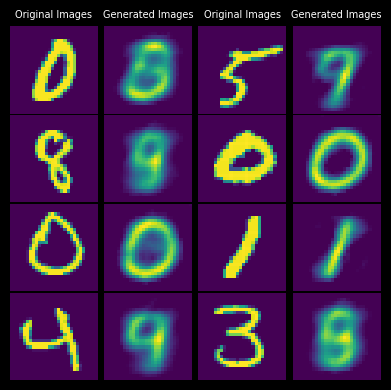

In [ ]:
#| echo: false
plt_subs(*get_valid_results(model, dls.train), size=2)

## Latent space exploration

* Lets see how our validation set gets mapped into embedding space via our encoder
    + the model is able to map each number into it's own subspace -- some overlap considerably more than others

## Function below needs to be modified/generalized

In [ ]:
#| fig-cap: "Figure 2: Embedding Space and Latent Reconstructions"
#| fig-subcap:
#|   - "left: embedding scatter plot <br> right: reconstructed latents"
#plot_latent_regen(model, min=-100, max=100)